# German Credit Risk Classification

![](https://d30pf83g3s2iw3.cloudfront.net/wp-content/uploads/2019/11/debit-vs-credit-card-holiday-shopping.gif)

# Content

The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.

# The following steps were followed in this project:
1. Import Modules and Data
1. Data Analysis
1. Data Classification
1. Data Visualization
1. Data Preprocessing
1. Building Models
    - DecisionTree Model
    - GradientBoosting Model
    - XGBoost Model
    - LightGBM Model

# Import Modules and Data

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [6]:
df=pd.read_csv("../input/german-credit-data-with-risk/german_credit_data.csv")
#Link data : https://www.kaggle.com/kabure/german-credit-data-with-risk?select=german_credit_data.csv
df=df.iloc[:,1:]
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Variable Description

In [7]:
values = [list(df.columns), #1st col
  ["Age of the person applying for the credit.",
  "Gender of the person applying for the credit.",
  "0,1,2,3 The values specified for the job in the form of 0,1,2,3.",
  "own, rent or free.",
  "The amount of money in the person's bank account.",
  "Cheque account.",
  "Credit amount.",
  "Time given for credit payment.",
  "Goal of credit application.",
  "Credit application positive or negative."]]

fig = go.Figure(data=[go.Table(
  columnorder = [1,2,3,4],
  columnwidth = [80,400],
  header = dict(
    values = [['<b>Columns</b>'],
                  ['<b>Description</b>']],
    line_color='#515A5A',
    fill_color='#515A5A',
    align=['left','center'],
    font=dict(color='white', size=12),
    height=40
  ),
  cells=dict(
    values=values,
    line_color='darkslategray',
    fill=dict(color=['#F7DC6F', '#82E0AA']),
    align=['left', 'center'],
    font_size=12,
    height=25)
    )
])
fig.show()

# Data Analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [9]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [10]:
df.corr()

,Age,Job,Credit amount,Duration
Age,1.000000,0.015673,0.032716,-0.036136
Job,0.015673,1.000000,0.285385,0.210910
Credit amount,0.032716,0.285385,1.000000,0.624984
Duration,-0.036136,0.210910,0.624984,1.000000


In [11]:
def unique_value(data_set, column_name):
    return data_set[column_name].nunique()

print("Number of the Unique Values:")
print(unique_value(df,list(df.columns)))

Number of the Unique Values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64


In [12]:
def missing_value_table(df):
    missing_value = df.isna().sum().sort_values(ascending=False)
    missing_value_percent = 100 * df.isna().sum()//len(df)
    missing_value_table = pd.concat([missing_value, missing_value_percent], axis=1)
    missing_value_table_return = missing_value_table.rename(columns = {0 : 'Missing Values', 1 : '% Value'})
    cm = sns.light_palette("lightgreen", as_cmap=True)
    missing_value_table_return = missing_value_table_return.style.background_gradient(cmap=cm)
    return missing_value_table_return
  
missing_value_table(df)

,Missing Values,% Value
Checking account,394,39
Saving accounts,183,18
Risk,0,0
Purpose,0,0
Duration,0,0
Credit amount,0,0
Housing,0,0
Job,0,0
Sex,0,0
Age,0,0


In [13]:
pd.crosstab(df["Sex"],df["Risk"])

Risk,bad,good
Sex,,
female,109,201
male,191,499


In [14]:
pd.crosstab(df["Housing"],df["Risk"])

Risk,bad,good
Housing,,
free,44,64
own,186,527
rent,70,109


In [15]:
# This code gives a error Dummy. That reason, we  leave to shaped of Notebook
#pd.crosstab(df["Housing"],df["Risk"],df["Credit amount"],aggfunc=["mean"],normalize=True)

* There is multiple groups in the "Purpose".
* At this situation we can apply ANOVA test.
* This way we will see the differences  according to requisition of Credit Amount.

In [16]:
df.head(2)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad


In [17]:
from scipy import stats

df1 = df.copy()

df1 = df1[["Credit amount","Purpose"]]

group = pd.unique(df1.Purpose.values)

d_v1 = {grp:df1["Credit amount"][df1.Purpose == grp] for grp in group}


* One of conditions ANOVA test is equal variance.

* Applied levene and according to result, between groups variances are not equal.

In [18]:
# Applying levene
stats.levene(d_v1['radio/TV'],d_v1['furniture/equipment'],d_v1['car'],d_v1['business'],d_v1['domestic appliances'],d_v1['repairs'],
                     d_v1['vacation/others'],d_v1['education'])

LeveneResult(statistic=11.506286350981943, pvalue=4.177745359274538e-14)

* P value << 0.05

In [19]:
f, p = stats.f_oneway(d_v1['radio/TV'],d_v1['furniture/equipment'],d_v1['car'],d_v1['business'],d_v1['domestic appliances'],d_v1['repairs'],
                     d_v1['vacation/others'],d_v1['education'])

("F statistics: "+str(f)+" | P value : "+str(p))

'F statistics: 13.34142171179633 | P value : 1.585947764999813e-16'

* H0: There are no significant differences means of groups.

* H1: At least one group's mean is different.

* P value < 0.05

* Reject h0 hypothesis

In [20]:
(df.groupby(by=["Purpose"])[["Credit amount"]].agg("sum") / df["Credit amount"].sum())*100

,Credit amount
Purpose,
business,12.329507
car,38.819347
domestic appliances,0.549513
education,5.192895
furniture/equipment,16.969771
radio/TV,21.292818
repairs,1.834707
vacation/others,3.011441


* In the result, there is different between groups.
* In this query we can see difference

# Data Classification

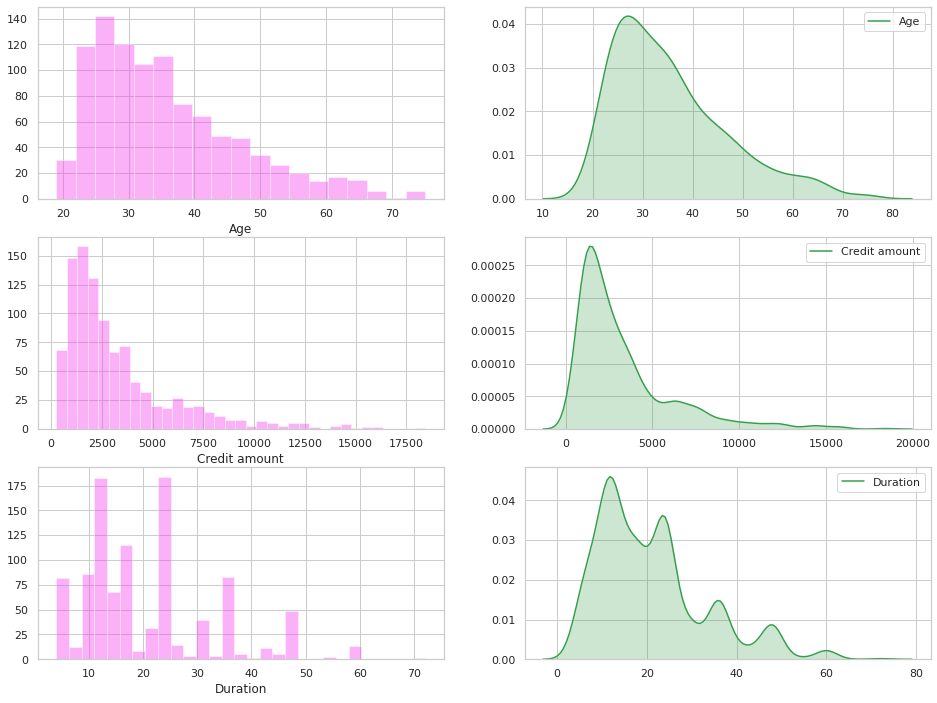

In [21]:
sns.set(font_scale=1,style="whitegrid")
fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(16,12))
cat_list=["Age","Credit amount","Duration"]
count=0
for i in range(3):
    sns.distplot(df[cat_list[count]],ax=ax[i][0],kde=False,color="#F43EEC")
    sns.kdeplot(df[cat_list[count]],ax=ax[i][1],shade=True,color="#359F4B")
    count+=1

* "monthly pay" and "credit amount^2"(square) added in data frame.

In [22]:
df["Monthly pay"] = (df["Credit amount"] / df["Duration"])
df["Credit amount^2"] = df["Credit amount"]**2

* 'Age' and 'Duration' columns Classification

In [23]:
df.insert(1,"Cat Age",np.NaN)
df.loc[df["Age"]<25,"Cat Age"]="0-25"
df.loc[((df["Age"]>=25) & (df["Age"]<30)),"Cat Age"]="25-30"
df.loc[((df["Age"]>=30) & (df["Age"]<35)),"Cat Age"]="30-35"
df.loc[((df["Age"]>=35) & (df["Age"]<40)),"Cat Age"]="35-40"
df.loc[((df["Age"]>=40) & (df["Age"]<50)),"Cat Age"]="40-50"
df.loc[((df["Age"]>=50) & (df["Age"]<76)),"Cat Age"]="50-75"

In [24]:
df.insert(9,"Cat Duration",df["Duration"])
for i in df["Cat Duration"]:
    if i<12:
        df["Cat Duration"]=df["Cat Duration"].replace(i,"0-12")
    elif (i>=12) and (i<24):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"12-24")
    elif (i>=24) and (i<36):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"24-36")
    elif (i>=36) and (i<48):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"36-48")
    elif (i>=48) and (i<60):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"48-60")
    elif (i>=60) and (i<=72):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"60-72")

In [25]:
df.insert(4,"Cat Job",df["Job"])
df["Cat Job"]=df["Cat Job"].astype("category")
df["Cat Job"]=df["Cat Job"].replace(0,"unskilled")
df["Cat Job"]=df["Cat Job"].replace(1,"resident")
df["Cat Job"]=df["Cat Job"].replace(2,"skilled")
df["Cat Job"]=df["Cat Job"].replace(3,"highly skilled")

In [26]:
df["Job"]=pd.Categorical(df["Job"],categories=[0,1,2,3],ordered=True)
df["Cat Age"]=pd.Categorical(df["Cat Age"],categories=['0-25','25-30', '30-35','35-40','40-50','50-75'])
df["Cat Duration"]=pd.Categorical(df["Cat Duration"],categories=['0-12','12-24', '24-36','36-48','48-60','60-72'])

In [27]:
df.head()

,Age,Cat Age,Sex,Job,Cat Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Cat Duration,Purpose,Risk,Monthly pay,Credit amount**2
0,67,50-75,male,2,skilled,own,NaN,little,1169,6,0-12,radio/TV,good,194.833333,1366561
1,22,0-25,female,2,skilled,own,little,moderate,5951,48,48-60,radio/TV,bad,123.979167,35414401
2,49,40-50,male,1,resident,own,little,NaN,2096,12,12-24,education,good,174.666667,4393216
3,45,40-50,male,2,skilled,free,little,little,7882,42,36-48,furniture/equipment,good,187.666667,62125924
4,53,50-75,male,2,skilled,free,little,little,4870,24,24-36,car,bad,202.916667,23716900


# Data Visualization

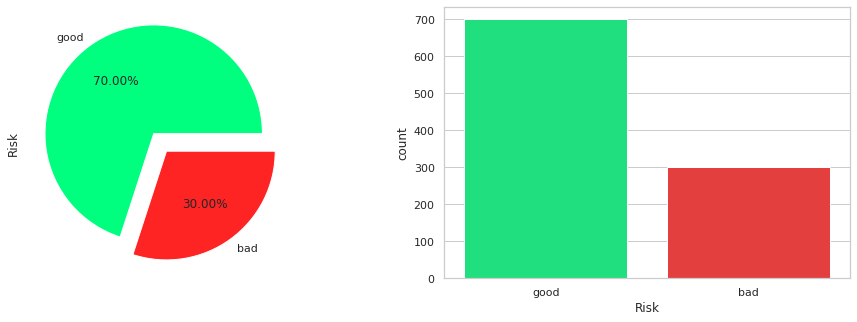

In [28]:
fig,ax=plt.subplots(ncols=2,figsize=(16,5))
df["Risk"].value_counts().plot.pie(autopct="%.2f%%",colors=['#00FF7F','#FF2424'],explode = (0.1, 0.1),ax=ax[0])
sns.countplot(df["Risk"],ax=ax[1],palette=['#00FF7F','#FF2424'])

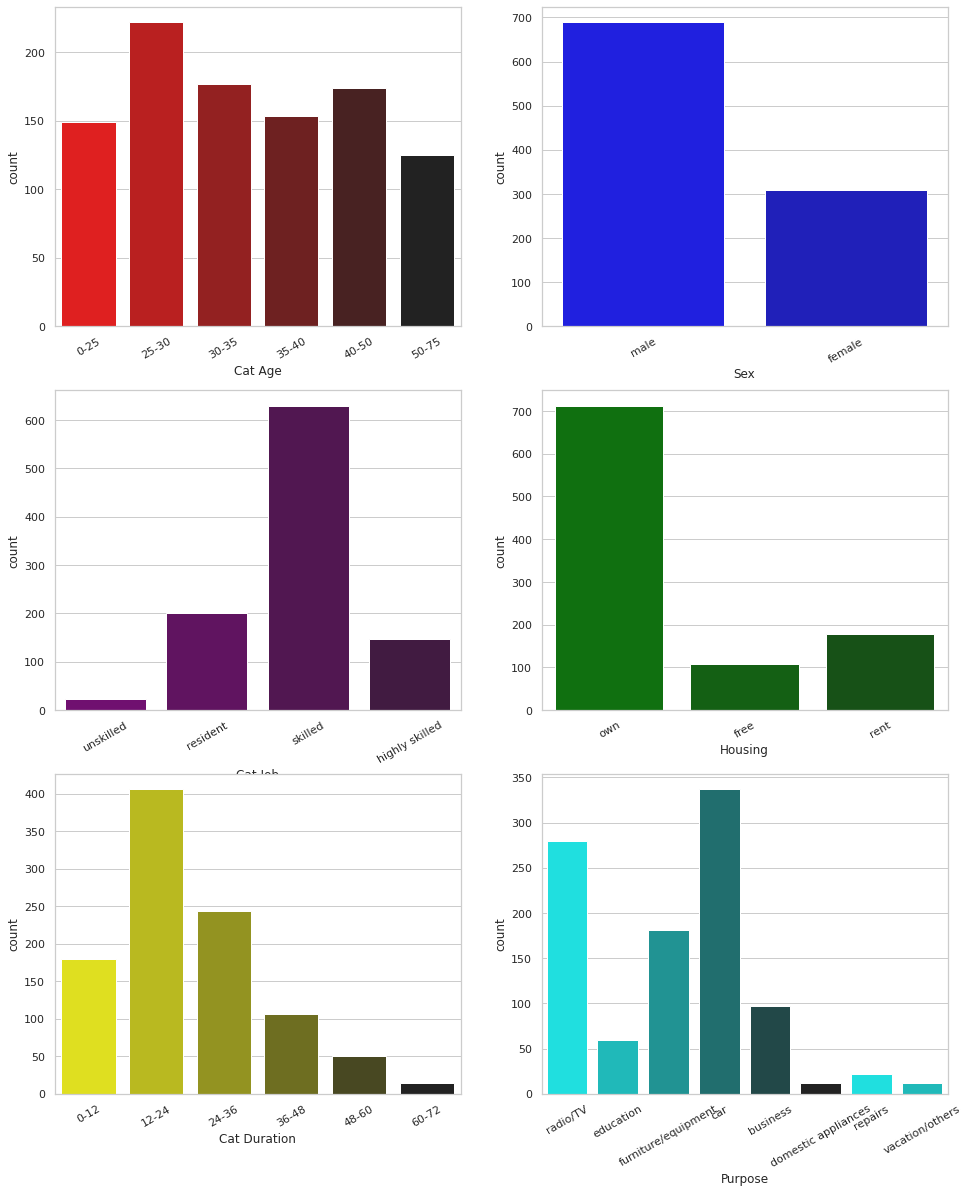

In [29]:
fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(16,20))
cat_list=["Cat Age","Sex","Cat Job","Housing","Cat Duration","Purpose"]
palette=["red","blue","purple","green","yellow","cyan"]
count=0
for i in range(3):
    for j in range(2):
        sns.countplot(df[cat_list[count]],ax=ax[i][j],palette=sns.dark_palette(palette[count],reverse=True))
        ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(),rotation=30)
        count+=1

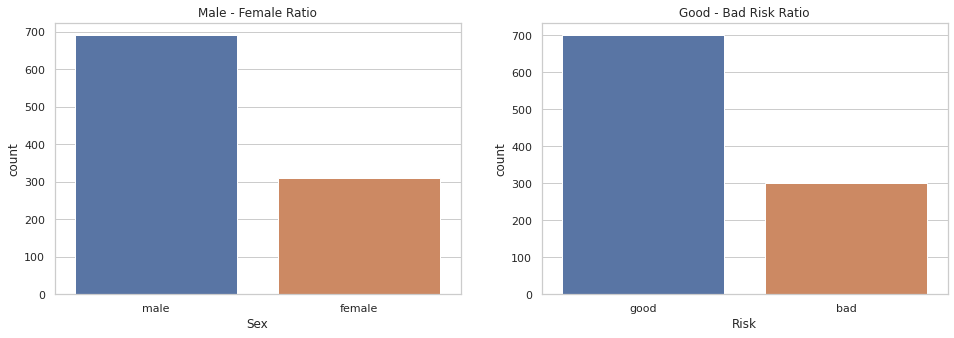

In [30]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

sns.countplot(df['Sex'], ax=ax[0]).set_title('Male - Female Ratio');
sns.countplot(df.Risk, ax=ax[1]).set_title('Good - Bad Risk Ratio');

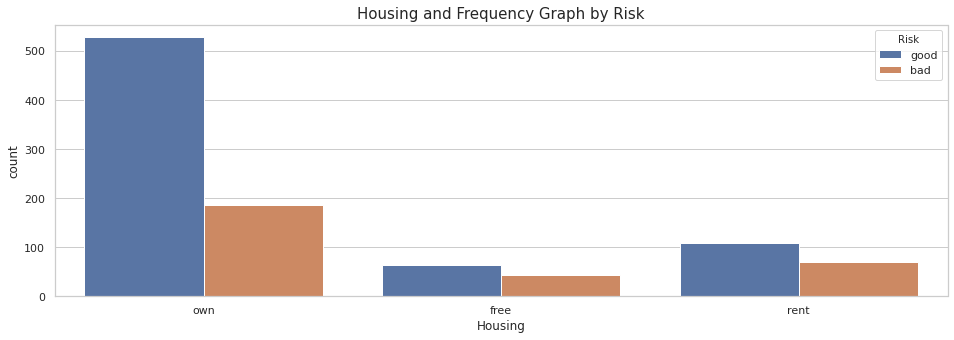

In [31]:
plt.figure(figsize=(16,5))
sns.countplot(x="Housing", hue="Risk", data=df).set_title("Housing and Frequency Graph by Risk", fontsize=15);
plt.show()

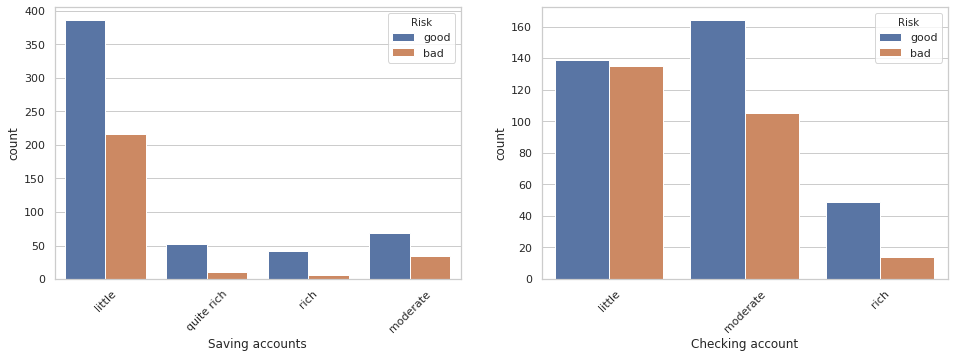

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
sns.countplot(x="Saving accounts", hue="Risk", data=df, ax=ax1);
sns.countplot(x="Checking account", hue="Risk", data=df, ax=ax2);
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
fig.show()

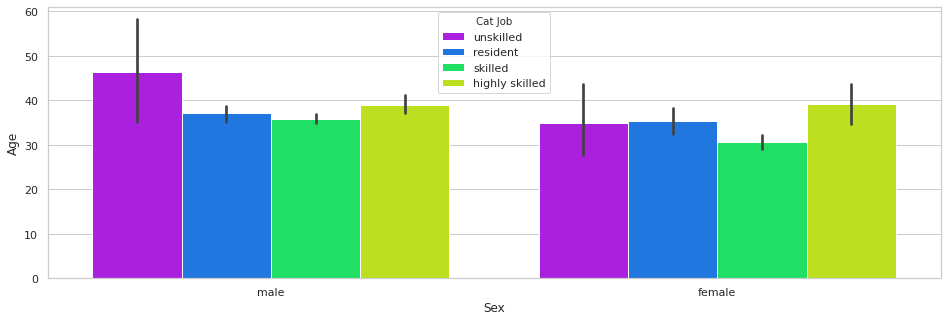

In [33]:
plt.figure(figsize=(16,5))
sns.barplot(data=df,x="Sex",y="Age",hue="Cat Job",palette="hsv_r")

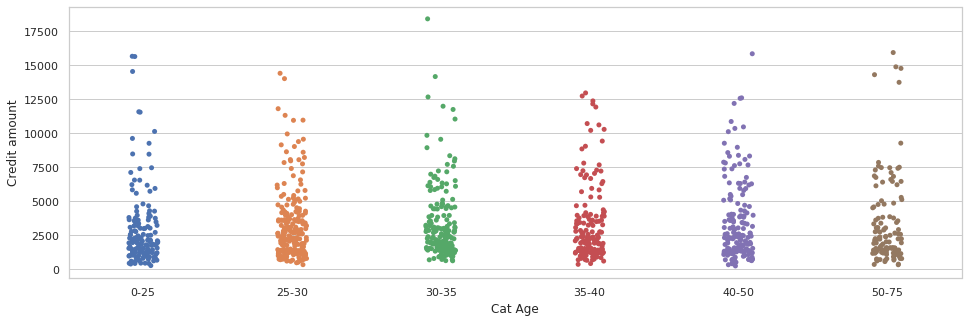

In [34]:
plt.figure(figsize = (16, 5))
sns.stripplot(x = "Cat Age", y = "Credit amount", data = df)

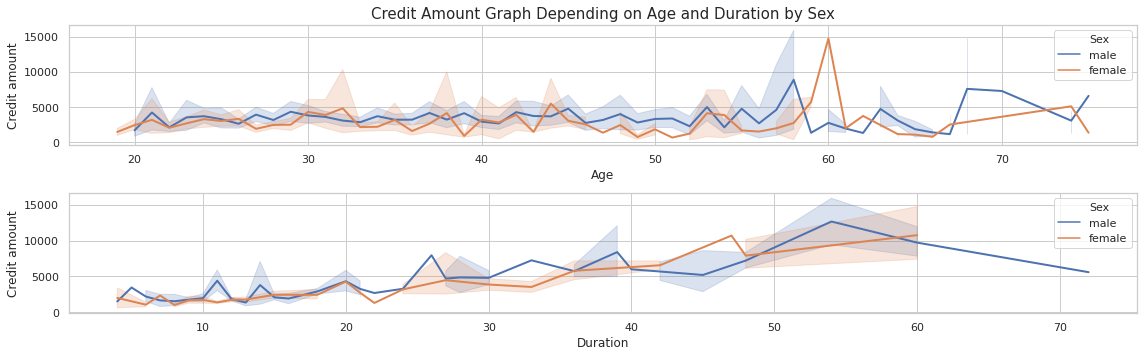

In [35]:
fig, ax = plt.subplots(2,1,figsize=(16,5))
plt.tight_layout(2)
sns.lineplot(data=df, x='Age', y='Credit amount', hue='Sex', lw=2, ax=ax[0]).set_title("Credit Amount Graph Depending on Age and Duration by Sex", fontsize=15);
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Sex', lw=2, ax=ax[1]);

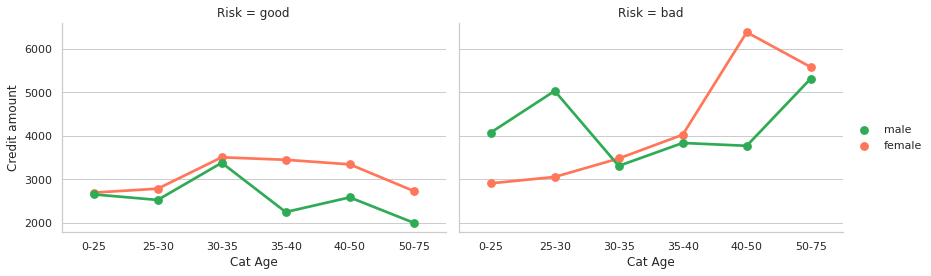

In [36]:
sns.FacetGrid(data=df,col="Risk",aspect=1.5,height=4).map(sns.pointplot,"Cat Age","Credit amount","Sex",palette=["#FF7659","#30AB55"],ci=None).add_legend();

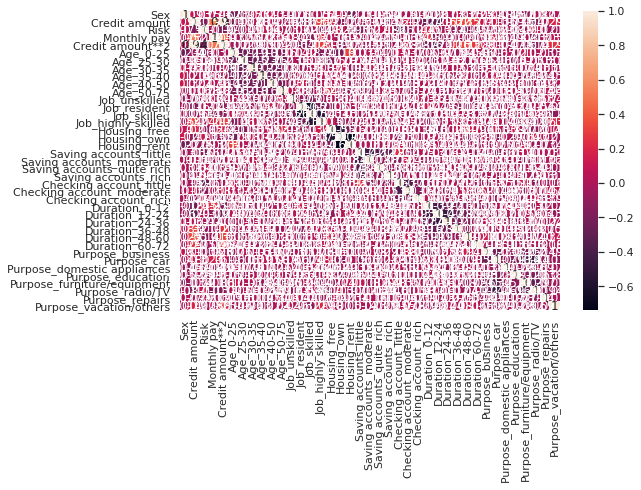

In [78]:
plt.figure(figsize=(8.5,5.5))
corr = sns.heatmap(df.corr(),xticklabels=df.corr().columns,yticklabels=df.corr().columns,annot=True)

# Data Preprocessing

In [38]:
df.head()

,Age,Cat Age,Sex,Job,Cat Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Cat Duration,Purpose,Risk,Monthly pay,Credit amount**2
0,67,50-75,male,2,skilled,own,NaN,little,1169,6,0-12,radio/TV,good,194.833333,1366561
1,22,0-25,female,2,skilled,own,little,moderate,5951,48,48-60,radio/TV,bad,123.979167,35414401
2,49,40-50,male,1,resident,own,little,NaN,2096,12,12-24,education,good,174.666667,4393216
3,45,40-50,male,2,skilled,free,little,little,7882,42,36-48,furniture/equipment,good,187.666667,62125924
4,53,50-75,male,2,skilled,free,little,little,4870,24,24-36,car,bad,202.916667,23716900


In [39]:
df["Age"],df["Duration"],df["Job"]=df["Cat Age"],df["Cat Duration"],df["Cat Job"]
df=df.drop(["Cat Age","Cat Duration","Cat Job"],axis=1)

In [40]:
liste_columns=list(df.columns)
liste_columns.remove("Sex")
liste_columns.remove("Risk")
liste_columns.remove("Credit amount")
liste_columns.remove("Monthly pay")
liste_columns.remove("Credit amount**2")

In [41]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
df["Sex"]=label.fit_transform(df["Sex"])
df["Risk"]=label.fit_transform(df["Risk"])
df=pd.get_dummies(df,columns=liste_columns,prefix=liste_columns)

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df["Credit amount"]=scaler.fit_transform(df[["Credit amount"]])
df["Monthly pay"]=scaler.fit_transform(df[["Monthly pay"]])
df["Credit amount**2"]=scaler.fit_transform(df[["Credit amount**2"]])

In [43]:
df.head()

,Sex,Credit amount,Risk,Monthly pay,Credit amount**2,Age_0-25,Age_25-30,Age_30-35,Age_35-40,Age_40-50,...,Duration_48-60,Duration_60-72,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,1,0.050567,1,0.069461,0.003842,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0.313690,0,0.040642,0.104166,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1,0.101574,1,0.061259,0.012761,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,0.419941,1,0.066546,0.182872,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1,0.254209,0,0.072749,0.069699,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Building Models

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,auc,classification_report

In [45]:
X=df.drop(["Risk"],axis=1)
Y=df["Risk"]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)

## Decision Tree Model

In [46]:
from sklearn.tree import DecisionTreeClassifier
cart_model=DecisionTreeClassifier(criterion='gini',max_depth=4,min_samples_leaf=54,min_samples_split=2).fit(X_train,Y_train)

In [47]:
print("Train Accuracy Score : ",accuracy_score(Y_train,cart_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,cart_model.predict(X_test)))

Train Accuracy Score :  0.7571428571428571
Test Accuracy Score :  0.71


In [48]:
print(classification_report(Y_test,cart_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.49      0.44      0.47        86
           1       0.78      0.82      0.80       214

    accuracy                           0.71       300
   macro avg       0.64      0.63      0.63       300
weighted avg       0.70      0.71      0.70       300



## GradientBoosting Model

In [49]:
from sklearn.ensemble import GradientBoostingClassifier
gbm_model = GradientBoostingClassifier(learning_rate = 0.01,max_depth = 5,min_samples_split = 10,n_estimators = 100).fit(X_train, Y_train)

In [50]:
print("Train Accuracy Score : ",accuracy_score(Y_train,gbm_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,gbm_model.predict(X_test)))

Train Accuracy Score :  0.8385714285714285
Test Accuracy Score :  0.74


In [51]:
print(classification_report(Y_test,gbm_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.65      0.20      0.30        86
           1       0.75      0.96      0.84       214

    accuracy                           0.74       300
   macro avg       0.70      0.58      0.57       300
weighted avg       0.72      0.74      0.69       300



In [52]:
X_train.shape

(700, 38)

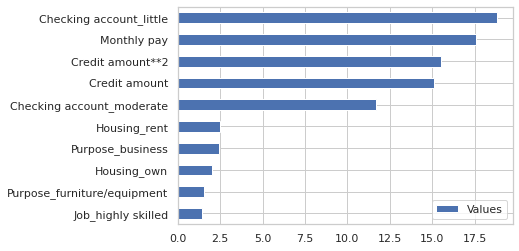

In [53]:
Importance=pd.DataFrame({"Values":gbm_model.feature_importances_*100},index=list(X_test.columns))
Importance.sort_values("Values",inplace=True,ascending=True)
Importance[28:].plot.barh()

## XGBoost Model

In [54]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate = 0.05, max_depth = 5,n_estimators=100,subsample=0.8).fit(X_train,Y_train)

In [55]:
print("Train Accuracy Score : ",accuracy_score(Y_train,xgb_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,xgb_model.predict(X_test)))

Train Accuracy Score :  0.9014285714285715
Test Accuracy Score :  0.7633333333333333


In [56]:
print(classification_report(Y_test,xgb_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.63      0.42      0.50        86
           1       0.79      0.90      0.84       214

    accuracy                           0.76       300
   macro avg       0.71      0.66      0.67       300
weighted avg       0.75      0.76      0.75       300



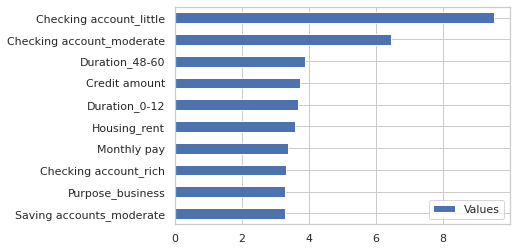

In [57]:
Importance=pd.DataFrame({"Values":xgb_model.feature_importances_*100},index=list(X_test.columns))
Importance.sort_values("Values",inplace=True,ascending=True)
Importance[28:].plot.barh()

## LightGBM Model

In [58]:
from lightgbm import LGBMClassifier
lgbm_model=LGBMClassifier(learning_rate=0.02,max_depth=3,min_child_samples=10,n_estimators=200,subsample=0.6).fit(X_train,Y_train)

In [59]:
print("Train Accuracy Score : ",accuracy_score(Y_train,lgbm_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,lgbm_model.predict(X_test)))

Train Accuracy Score :  0.8142857142857143
Test Accuracy Score :  0.73


In [60]:
print(classification_report(Y_test,lgbm_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.56      0.26      0.35        86
           1       0.75      0.92      0.83       214

    accuracy                           0.73       300
   macro avg       0.66      0.59      0.59       300
weighted avg       0.70      0.73      0.69       300



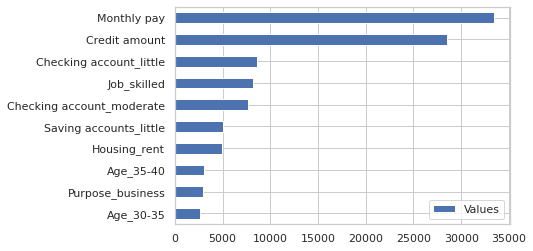

In [61]:
Importance=pd.DataFrame({"Values":lgbm_model.feature_importances_*100},index=list(X_test.columns))
Importance.sort_values("Values",inplace=True,ascending=True)
Importance[28:].plot.barh()

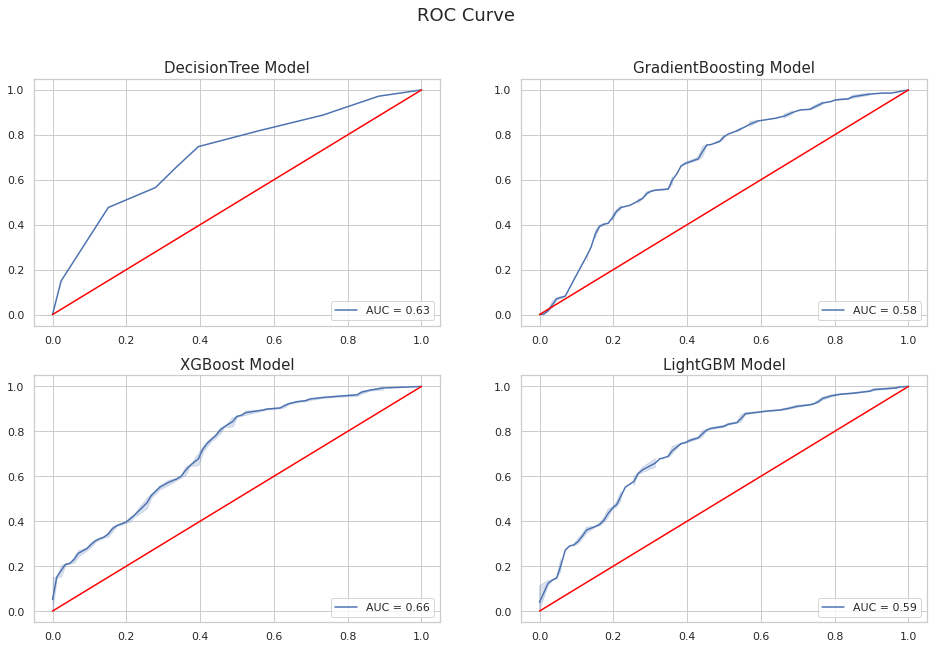

In [62]:
list_model=[cart_model,gbm_model,xgb_model,lgbm_model]
list_model_name=["DecisionTree Model","GradientBoosting Model","XGBoost Model","LightGBM Model"]
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(16,10))
count=0
for i in range(2):
    for j in range(2):
        if count==0:
            logit_roc_auc=roc_auc_score(Y_test,list_model[count].predict(X_test))
            fpr,tpr,thresholds = roc_curve(Y_test,list_model[count].predict_proba(X_test)[:,1])
        else:
            logit_roc_auc=roc_auc_score(Y_test,list_model[count].predict(X_test))
            fpr,tpr,thresholds = roc_curve(Y_test,list_model[count].predict_proba(X_test)[:,1])
        sns.lineplot(fpr,tpr,label="AUC = %0.2f"%logit_roc_auc,ax=ax[i][j])
        sns.lineplot([0,1],[0,1],color="red",ax=ax[i][j])
        ax[i][j].legend(loc="lower right")
        ax[i][j].set_title(list_model_name[count],fontsize=15)
        count+=1
fig.suptitle("ROC Curve",fontsize=18);

In [63]:
model_data=pd.DataFrame({"Model":["DecisionTree Model","GradientBoosting Model","XGBoost Model","LightGBM Model"],
                   "Train Accuracy":[accuracy_score(Y_train,cart_model.predict(X_train)),accuracy_score(Y_train,gbm_model.predict(X_train)),accuracy_score(Y_train,xgb_model.predict(X_train)),accuracy_score(Y_train,lgbm_model.predict(X_train))],
                   "Test Accuracy":[accuracy_score(Y_test,cart_model.predict(X_test)),accuracy_score(Y_test,gbm_model.predict(X_test)),accuracy_score(Y_test,xgb_model.predict(X_test)),accuracy_score(Y_test,lgbm_model.predict(X_test))]})

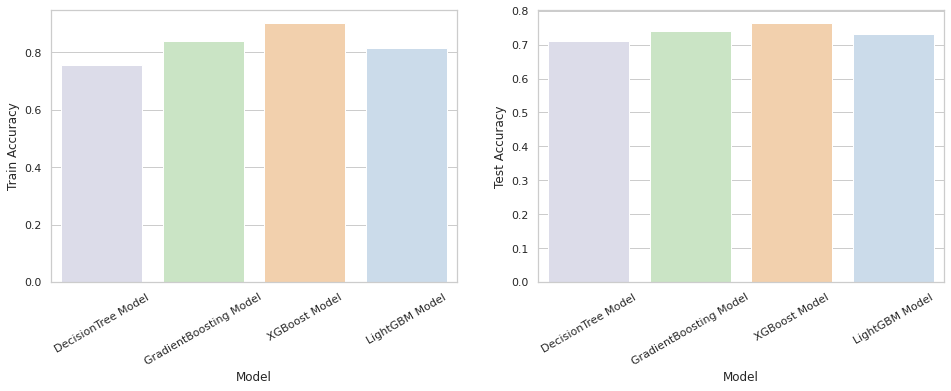

In [64]:
fig,ax=plt.subplots(ncols=2,figsize=(16,5))
sns.barplot(x="Model",y="Train Accuracy",data=model_data,ax=ax[0],palette="tab20c_r")
sns.barplot(x="Model",y="Test Accuracy",data=model_data,ax=ax[1],palette="tab20c_r")
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=30)
ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=30);

* We saw some important Features at the models results.
* Now, we are creating a Tree image.
* This Tree image shows us to what's going on the behind.

In [65]:
df.head(1)

,Sex,Credit amount,Risk,Monthly pay,Credit amount**2,Age_0-25,Age_25-30,Age_30-35,Age_35-40,Age_40-50,...,Duration_48-60,Duration_60-72,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,1,0.050567,1,0.069461,0.003842,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


* Selection 4 features according to importance

In [66]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

variable = ["Risk","Monthly pay","Credit amount","Checking account_little","Checking account_moderate"]

data = df.loc[:,variable]

data.head(2)

,Risk,Monthly pay,Credit amount,Checking account_little,Checking account_moderate
0,1,0.069461,0.050567,1,0
1,0,0.040642,0.313690,0,1


In [67]:
X = data.drop("Risk",axis=1)
y = data["Risk"]

forest = RandomForestClassifier(max_depth = 3, n_estimators=4)
forest.fit(X,y)

RandomForestClassifier(max_depth=3, n_estimators=4)

In [68]:
estimator = forest.estimators_[3]

In [69]:
target_names = ["0: good","1: bad"]

In [70]:
from sklearn.tree import export_graphviz

export_graphviz(estimator,out_file="tree_limited.dot",feature_names=X.columns,
                class_names=target_names,rounded = True, proportion = False, precision = 2, filled = True)

In [71]:
forest_1 = RandomForestClassifier(max_depth = None, n_estimators=4)
forest_1 = forest_1.fit(X,y)
estimator_non = forest_1.estimators_[3]

In [72]:
export_graphviz(estimator_non, out_file='tree_nonlimited.dot', feature_names = X.columns,
                class_names = target_names,
                rounded = True, proportion = False, precision = 2, filled = True)

In [73]:
!dot -Tpng tree_limited.dot -o tree_limited.png -Gdpi=600

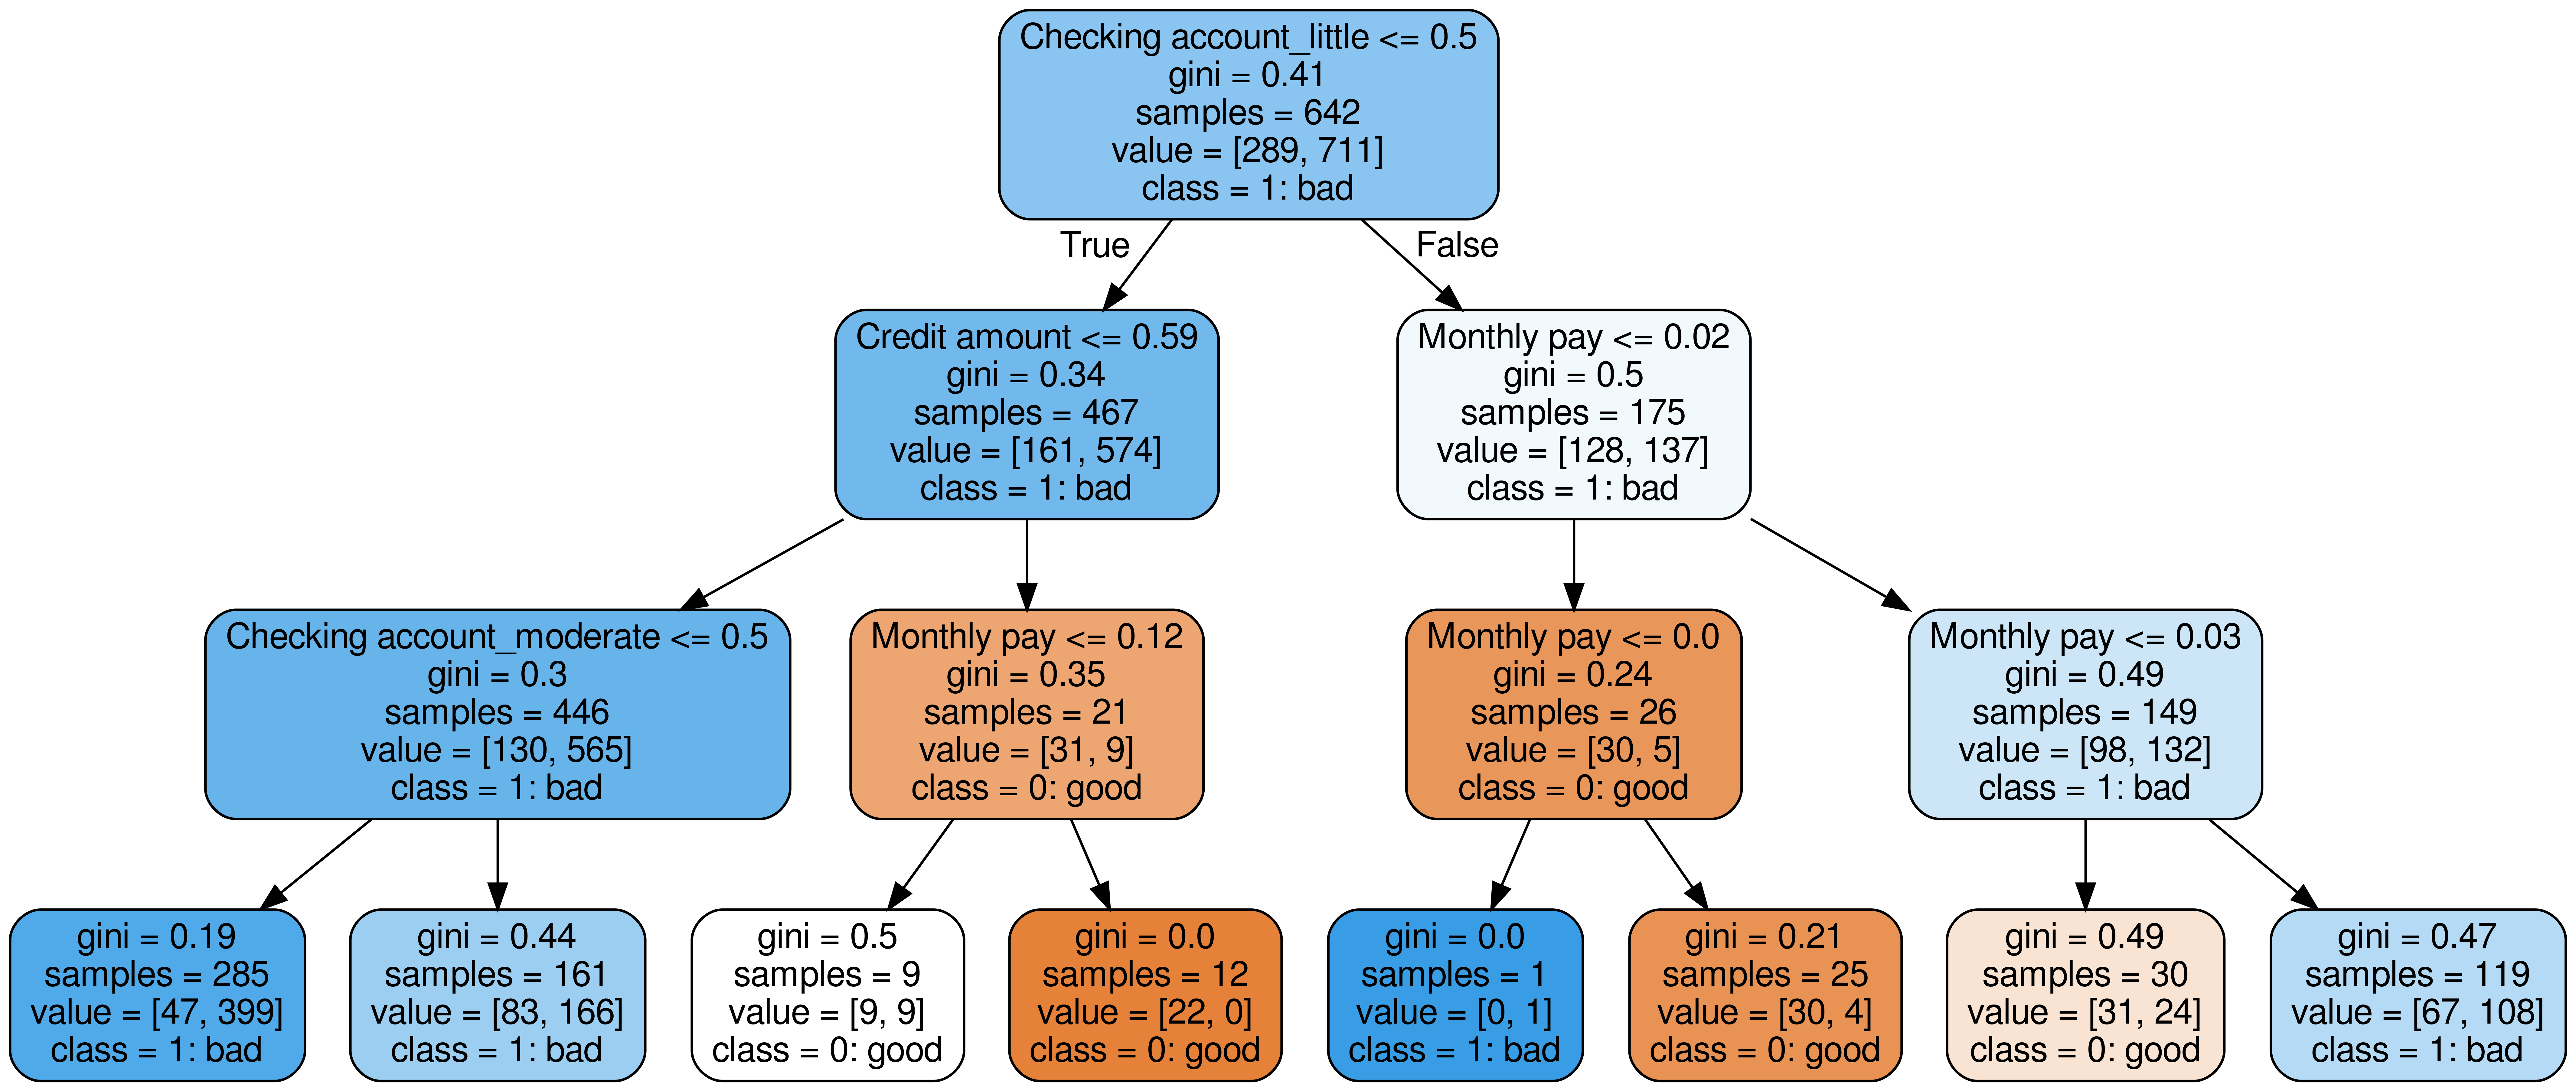

In [74]:
from IPython.display import Image
Image(filename = 'tree_limited.png')